In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def single_sgoop_potential(x, y):
    return (
        -12 * np.exp(-4.5 * np.square(x + 0.75) - 3 * np.square(y + 0.5))
        - 16 * np.exp(-2 * np.square(x) - 2 * np.square(y - 1))
        - 12 * np.exp(-4.5 * np.square(x - 0.75) - 3 * np.square(y + 0.5))
        + 0.05 * (np.power(x, 6) + np.power(y, 6))
    )

def double_sgoop_potential(x, y):
    return (
        -12 * np.exp(-4.5 * np.square(x + 0.55) - 3 * np.square(y + 0.5))
        - 16 * np.exp(-2 * np.square(x) - 2 * np.square(y - 1))
        - 12 * np.exp(-4.5 * np.square(x - 0.55) - 3 * np.square(y + 0.5))
        + 0.05 * (np.power(x, 6) + np.power(y, 6))
    )

In [3]:
def boltzmann_prob(pos0, pos1, potential, kt):
    e0 = potential(*pos0.T) 
    e1 = potential(*pos1.T)
    if e1 < e0:
        return 1.0
    return np.exp((e0 - e1) / kt)

np.random.seed(24)
def monte_carlo_simulation(
    potential,
    pos_0=(0, 0),
    step_size=(0.04, 0.04), 
    num_steps=50000, 
    kt=1.0
):
    pos = np.array(pos_0)
    results = np.ndarray([num_steps, 2])
    for idx in range(num_steps):
        step = np.array(
            random.choice(
                [(1, 0), (-1, 0),
                 (1, 1), (-1, 1),
                 (1, -1), (-1, -1),
                 (0, 1), (0, -1)]
            )
        ) * np.array(step_size)
        new_pos = pos + step
        prob = boltzmann_prob(pos, new_pos, potential, kt)
        if prob >= np.random.random():
            pos = new_pos
        results[idx, :] = pos
    return results

# when only one RC will do

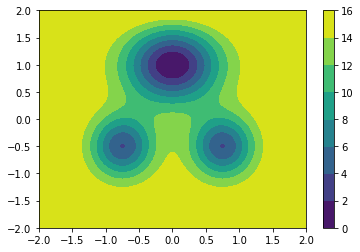

In [4]:
xaxis = np.linspace(-2.0, 2.0, 100)
yaxis = np.linspace(-2.0, 2.0, 100)

result = single_sgoop_potential(xaxis[:, None], yaxis[None, :])
# shift and clip high values
max_val = 16
result -= result.min()
result[result > max_val] = max_val
# plot energy
plt.contourf(xaxis, yaxis, result.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')

### running a monte carlo simulation

In [33]:
simulation_results = monte_carlo_simulation(
    single_sgoop_potential, kt=3, num_steps=500000
)

(-2, 2)

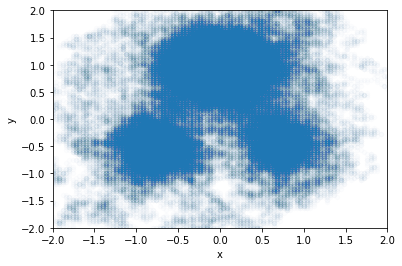

In [34]:
monte_carlo_traj = pd.DataFrame(simulation_results, columns=['x', 'y'])
monte_carlo_traj.plot.scatter(0, 1, alpha=0.01)
plt.ylim([-2, 2])
plt.xlim([-2, 2])

# finding optimal cv with sgoop

In [35]:
def angle_to_rc(angle):
    x = np.cos(angle)
    y = np.sin(angle)
    return np.array([x, y])

In [50]:
from sgoop.utilities import read_plumed_file
from sgoop.sgoop import rc_eval
from sgoop.visualization import plot_spectral_gap, plot_pmf

# specify columns you want to require
sgoop_params = {
    # specify rbias and cv column names
    'v_minus_c_col': None,
    'cv_cols': ['x', 'y'],
    # adjust sgoop params
    'rc_bins': 20,
    'wells': 2,
    'd': 1,
    'kde': False,
    'diffusivity': 0.5
}

# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi, 100)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    sg[idx] = rc_eval(
        rc, None, monte_carlo_traj, sgoop_params
    )
    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = np.array([np.cos(opt_theta), np.sin(opt_theta)])
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

rc 0:  angle:  0.000  sg:  0.006
rc 1:  angle:  0.032  sg:  0.007
rc 2:  angle:  0.063  sg:  0.008
rc 3:  angle:  0.095  sg:  0.008
rc 4:  angle:  0.127  sg:  0.008
rc 5:  angle:  0.159  sg:  0.008
rc 6:  angle:  0.190  sg:  0.009
rc 7:  angle:  0.222  sg:  0.009
rc 8:  angle:  0.254  sg:  0.009
rc 9:  angle:  0.286  sg:  0.009
rc10:  angle:  0.317  sg:  0.009
rc11:  angle:  0.349  sg:  0.009
rc12:  angle:  0.381  sg:  0.009
rc13:  angle:  0.413  sg:  0.010
rc14:  angle:  0.444  sg:  0.010
rc15:  angle:  0.476  sg:  0.010
rc16:  angle:  0.508  sg:  0.011
rc17:  angle:  0.539  sg:  0.011
rc18:  angle:  0.571  sg:  0.011
rc19:  angle:  0.603  sg:  0.011
rc20:  angle:  0.635  sg:  0.012
rc21:  angle:  0.666  sg:  0.012
rc22:  angle:  0.698  sg:  0.012
rc23:  angle:  0.730  sg:  0.012
rc24:  angle:  0.762  sg:  0.013
rc25:  angle:  0.793  sg:  0.013
rc26:  angle:  0.825  sg:  0.013
rc27:  angle:  0.857  sg:  0.013
rc28:  angle:  0.889  sg:  0.014
rc29:  angle:  0.920  sg:  0.014
rc30:  ang

In [48]:
# define trial RC for comparison
trial_rc = np.array([1, 0])
opt_rc = np.array([-0.65486073, 0.75574957])

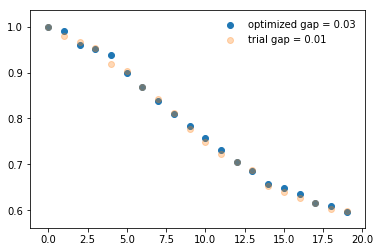

In [49]:
plot_spectral_gap(
    opt_rc, 
    monte_carlo_traj, 
    sgoop_params, 
    max_cal_traj=None,
    trial_rc=trial_rc,
)

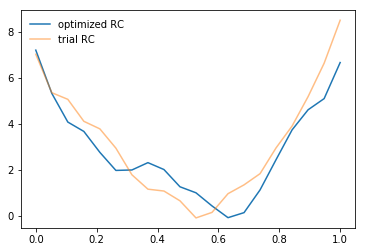

In [42]:
plot_pmf(
    opt_rc, 
    monte_carlo_traj, 
    sgoop_params, 
    trial_rc=trial_rc,
    normalize_grid=True
)

# when a one RC is not enough

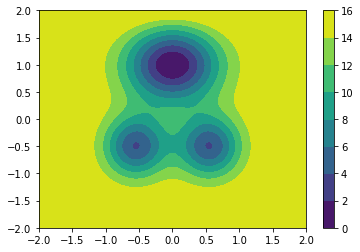

In [22]:
result = double_sgoop_potential(xaxis[:, None], yaxis[None, :])
# shift and clip high values
max_val = 16
result -= result.min()
result[result > max_val] = max_val
# plot energy
plt.contourf(xaxis, yaxis, result.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')

In [23]:
simulation_results = monte_carlo_simulation(
    double_sgoop_potential, kt=3, num_steps=500000
)

(-2, 2)

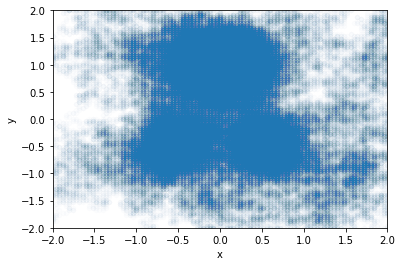

In [28]:
monte_carlo_traj = pd.DataFrame(simulation_results, columns=['x', 'y'])
monte_carlo_traj.plot.scatter(0, 1, alpha=0.01)
plt.ylim([-2, 2])
plt.xlim([-2, 2])

In [29]:
# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi, 100)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    sg[idx] = rc_eval(
        rc, None, monte_carlo_traj, sgoop_params
    )
    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = np.array([np.cos(opt_theta), np.sin(opt_theta)])
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

rc 0:  angle:  0.000  sg:  0.007
rc 1:  angle:  0.032  sg:  0.007
rc 2:  angle:  0.063  sg:  0.007
rc 3:  angle:  0.095  sg:  0.007
rc 4:  angle:  0.127  sg:  0.007
rc 5:  angle:  0.159  sg:  0.006
rc 6:  angle:  0.190  sg:  0.006
rc 7:  angle:  0.222  sg:  0.005
rc 8:  angle:  0.254  sg:  0.005
rc 9:  angle:  0.286  sg:  0.004
rc10:  angle:  0.317  sg:  0.004
rc11:  angle:  0.349  sg:  0.003
rc12:  angle:  0.381  sg:  0.003
rc13:  angle:  0.413  sg:  0.003
rc14:  angle:  0.444  sg:  0.002
rc15:  angle:  0.476  sg:  0.002
rc16:  angle:  0.508  sg:  0.002
rc17:  angle:  0.539  sg:  0.003
rc18:  angle:  0.571  sg:  0.003
rc19:  angle:  0.603  sg:  0.003
rc20:  angle:  0.635  sg:  0.003
rc21:  angle:  0.666  sg:  0.004
rc22:  angle:  0.698  sg:  0.004
rc23:  angle:  0.730  sg:  0.004
rc24:  angle:  0.762  sg:  0.005
rc25:  angle:  0.793  sg:  0.006
rc26:  angle:  0.825  sg:  0.006
rc27:  angle:  0.857  sg:  0.007
rc28:  angle:  0.889  sg:  0.008
rc29:  angle:  0.920  sg:  0.009
rc30:  ang

In [30]:
# define trial RC for comparison
trial_rc = np.array([1, 0])
opt_rc = np.array([0.20480667, 0.97880245])

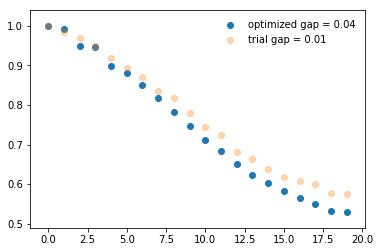

In [31]:
plot_spectral_gap(
    opt_rc, 
    monte_carlo_traj, 
    sgoop_params, 
    max_cal_traj=None,
    trial_rc=trial_rc,
)

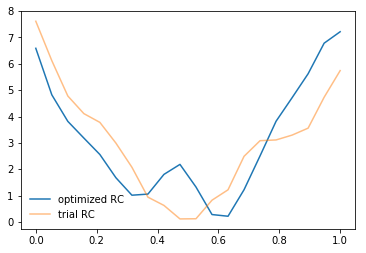

In [32]:
plot_pmf(
    opt_rc, 
    monte_carlo_traj, 
    sgoop_params, 
    trial_rc=trial_rc,
    normalize_grid=True
)

# SGOOP process:
1. calculate probability density along reaction coordinate
2. 